In [3]:
install.packages('devtools')
install.packages('glmnet')
install.packages('abind')

devtools::install_github("stephenslab/susieR@0.9.0")

library(MASS)
library(susieR)
library(glmnet)

Skipping install of 'susieR' from a github remote, the SHA1 (34021ad1) has not changed since last install.
  Use `force = TRUE` to force installation




The downloaded binary packages are in
	/var/folders/st/djlj7hzd17j_phn2zc8y8kzw0000gq/T//Rtmp7W21mL/downloaded_packages

The downloaded binary packages are in
	/var/folders/st/djlj7hzd17j_phn2zc8y8kzw0000gq/T//Rtmp7W21mL/downloaded_packages


In [55]:
#read realistic example LD data
ldlow = readRDS('/Users/bpasaniuc/Downloads/lowld.RData')
ldhigh = readRDS('/Users/bpasaniuc/Downloads/highld.RData')

In [5]:
##############Exercise 1
##############GOAL: To Assess impact of LD, effect size, sample size in fine-mapping
##############Compare standard strategies to identify causal variant under simple 1 causal scenario
##############TODO: Answer Questions marked with Q below to investigate the impact of its parameters  
############## on fine-mapping performance
############## 

#random seed; 
set.seed(1)

##############Parameters:

#number of variants/SNPs; 
#Q1: Investigate the performance of fine-mapping as number of causals increases M= 10, 50,100,500
#Q1: Which of the 5 inference methods below gives the correct answer? 
M = 10

#number of individuals; 
#Q2: Investigate the performance of fine-mapping as number of individuals increases N=100,1000,10000,100000
#Q2: Which of the 5 inference methods below gives the correct answer? 
N = 100

#strength of causal effects (in variance/heritability terms); 
#Q3: Investigate the performance of effect size h2g=0.001, 0.01, 0.05, 0.1 on fine-mapping accuracy
#Q3: which method of inferrence of causal variant gives correct answer
h2g = 0.01

#strength of LD; LD will decay exponentially farther from diagonal; 
#Q4: investigate impact of LD (theta=0,0.5,0.95,0.995) on fine-mapping inference
#Q4: Will any method give the correct answer?
theta=0.995


#Q5: Explore the interaction between M, N and effect size; what happens to the inferrence as number 
# of individuals/effect size increase? Which matters more? M, N or LD?

#causal vector indicator; this will specify which variants are causal and which ones are not
C = rep(0,M)
#one causal variant simulation; select one random SNP to be causal
C[sample(1:length(C),1)] = 1
#visualize C
C

[1] 0 0 0 0 0 0 0 0 1 0

In [18]:
#generate an LD matrix
#we set SNPs close to each other to have high correlation according to theta 
ld = diag(1,M,M)
for(row in 1:nrow(ld)) {
    for(col in row:ncol(ld))
    {
        ld[row,col] = theta^(col-row)
        ld[col,row] = ld [row,col]    
    }
}
#visualise ld
ld

[,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]     
 [1,] 1.0000000 0.9950000 0.9900250 0.9850749 0.9801495 0.9752488 0.9703725
 [2,] 0.9950000 1.0000000 0.9950000 0.9900250 0.9850749 0.9801495 0.9752488
 [3,] 0.9900250 0.9950000 1.0000000 0.9950000 0.9900250 0.9850749 0.9801495
 [4,] 0.9850749 0.9900250 0.9950000 1.0000000 0.9950000 0.9900250 0.9850749
 [5,] 0.9801495 0.9850749 0.9900250 0.9950000 1.0000000 0.9950000 0.9900250
 [6,] 0.9752488 0.9801495 0.9850749 0.9900250 0.9950000 1.0000000 0.9950000
 [7,] 0.9703725 0.9752488 0.9801495 0.9850749 0.9900250 0.9950000 1.0000000
 [8,] 0.9655206 0.9703725 0.9752488 0.9801495 0.9850749 0.9900250 0.9950000
 [9,] 0.9606930 0.9655206 0.9703725 0.9752488 0.9801495 0.9850749 0.9900250
[10,] 0.9558896 0.9606930 0.9655206 0.9703725 0.9752488 0.9801495 0.9850749
      [,8]      [,9]      [,10]    
 [1,] 0.9655206 0.9606930 0.9558896
 [2,] 0.9703725 0.9655206 0.9606930
 [3,] 0.9752488 0.9703725 0.9655206
 [4,] 0.9801495 0.9752488 0.9703725
 [5,] 0.9850749 0.9801495 0.9752488
 [6,] 0.9900250 0.9850749 0.9801495
 [7,] 0.9950000 0.9900250 0.9850749
 [8,] 1.0000000 0.9950000 0.9900250
 [9,] 0.9950000 1.0000000 0.9950000
[10,] 0.9900250 0.9950000 1.0000000

In [19]:
#generate causal effects according to variance parameter
#sample effect sizes at all SNPs
alpha = rnorm(n = M, mean = 0, sd = sqrt(h2g/sum(C)))
#keep non-zero effects only at causal variants
beta_true = C*alpha
#beta_true is the true causal effect size vector
beta_true

[1]  0.00000000  0.00000000  0.00000000  0.02329972  0.00000000  0.00000000
 [7]  0.00000000  0.00000000 -0.02159422  0.00000000

In [20]:
#sample a matrix of genotypes according to the LD correlation structure
#many ways to do it; for simplicity we just sample from a 
#multivariate normal distr with covariance specified by LD
#this step will take longer if N, M are large
#the LD matrix needs to be a covariance matrix
X = mvrnorm(n = N, mu = rep(0,M), Sigma = ld)

#note how the genotypes are not discrete (0,1,2);in real data they will be 0,1,2
X[1:10,1:10]

[,1]        [,2]        [,3]        [,4]        [,5]        [,6]        
 [1,] -0.27053915 -0.29683811 -0.43044676 -0.33089536 -0.35555233 -0.459783331
 [2,]  0.44775860  0.41780680  0.35744107  0.56184502  0.62348281  0.740713776
 [3,]  2.19329350  2.18967226  2.35266791  2.19801178  2.29071149  2.341165152
 [4,] -0.96179789 -1.14911611 -1.04693604 -1.10274612 -1.20015920 -1.290601884
 [5,]  0.17157437  0.14535757  0.09274505  0.09558188 -0.09197239 -0.009931768
 [6,]  0.09373697  0.04304611 -0.03324538  0.03631344  0.06195559  0.073444826
 [7,] -1.02187502 -0.89162396 -0.87373435 -0.97931263 -0.77225288 -0.867695852
 [8,] -0.80669476 -0.85142710 -0.82607710 -0.95334904 -0.91773266 -0.861670525
 [9,] -0.57275395 -0.54157566 -0.59287795 -0.64090197 -0.47884040 -0.591662981
[10,] -0.95719085 -0.95534779 -0.88047012 -0.77185448 -0.66202951 -0.831018874
      [,7]        [,8]        [,9]        [,10]      
 [1,] -0.45050982 -0.42727949 -0.44398685 -0.39972145
 [2,]  0.68661711  0.75880230  0.79727317  0.76920862
 [3,]  2.17638620  2.21697472  2.07673714  1.92706814
 [4,] -1.07503867 -1.13652660 -1.13124466 -1.06104934
 [5,] -0.09401270 -0.13570572  0.15899411  0.11579553
 [6,]  0.01262196 -0.04973929 -0.01508488 -0.06283571
 [7,] -0.94595300 -0.90134424 -1.04894971 -1.06058966
 [8,] -0.77747658 -0.61698568 -0.73634684 -0.79624689
 [9,] -0.57154317 -0.73957612 -0.64613894 -0.51415607
[10,] -0.96380449 -1.04621090 -1.03875473 -1.01051955

In [21]:
#generate phenotype as linear combination of genotypes with causal effects plus random noise
y = X %*% beta_true + rnorm(N,1-h2g)

y[1:10]


[1]  0.7755020 -0.6360630 -0.4545964  1.3396444  0.8142467  0.3997434
 [7] -0.3441937 -0.1136104  3.0251236  0.6679575

In [22]:
#now that we have genotype and phenotype we can perform inference
#usual inference is marginal regression of y on every SNP indepentently
#this gives us observed effects in GWAS as function of LD
#for simulations we can simulate sum stats directly (no X) (Q: why? homework)

beta_hat = mvrnorm(n = 1, mu = ld%*%beta_true, Sigma = ld*(1-h2g)/N)

#z-scores for association in GWAS
zsc = beta_hat*sqrt(N)

#p-values in GWAS
pvalslog10 = -log10(pchisq(zsc^2,1,lower.tail=F))

#Q6: Why is beta_true  different from beta_hat?
#Q7: Note how beta_hat varies as function of LD and beta_true; investigate how.
#Q8: Why are z-scores and beta_hat different?
#Q9: If increase N, what happens to the beta_hat? How about pvalues?

beta_true
beta_hat
zsc

[1]  0.00000000  0.00000000  0.00000000  0.02329972  0.00000000  0.00000000
 [7]  0.00000000  0.00000000 -0.02159422  0.00000000

[1] -0.05738610 -0.07290761 -0.07580713 -0.08240845 -0.06974852 -0.06573372
 [7] -0.06838586 -0.05745787 -0.06354032 -0.06527565

[1] -0.5738610 -0.7290761 -0.7580713 -0.8240845 -0.6974852 -0.6573372
 [7] -0.6838586 -0.5745787 -0.6354032 -0.6527565

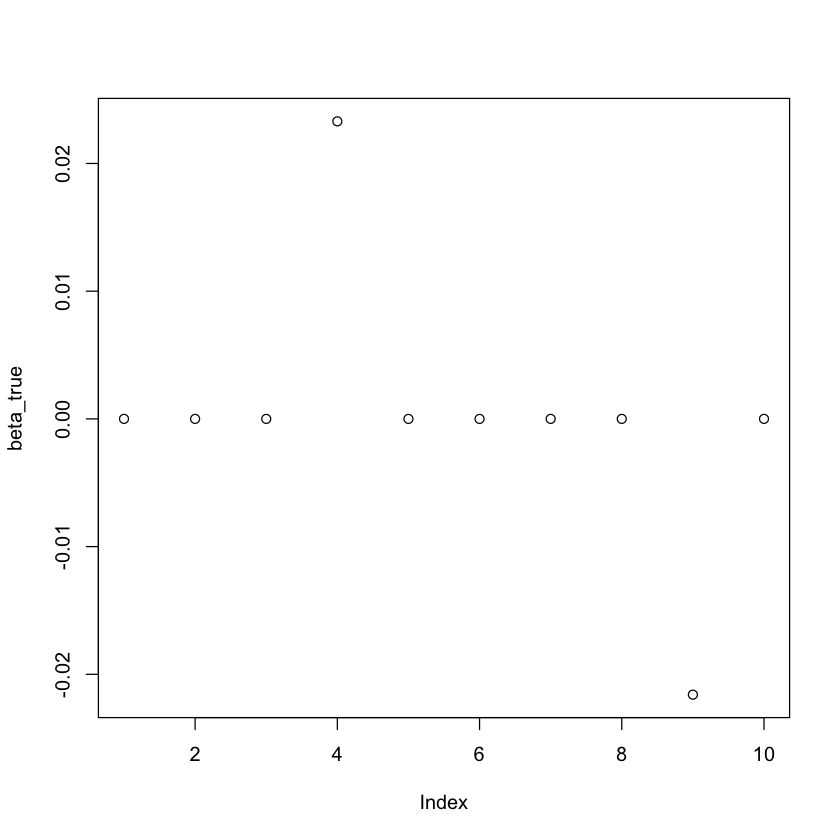

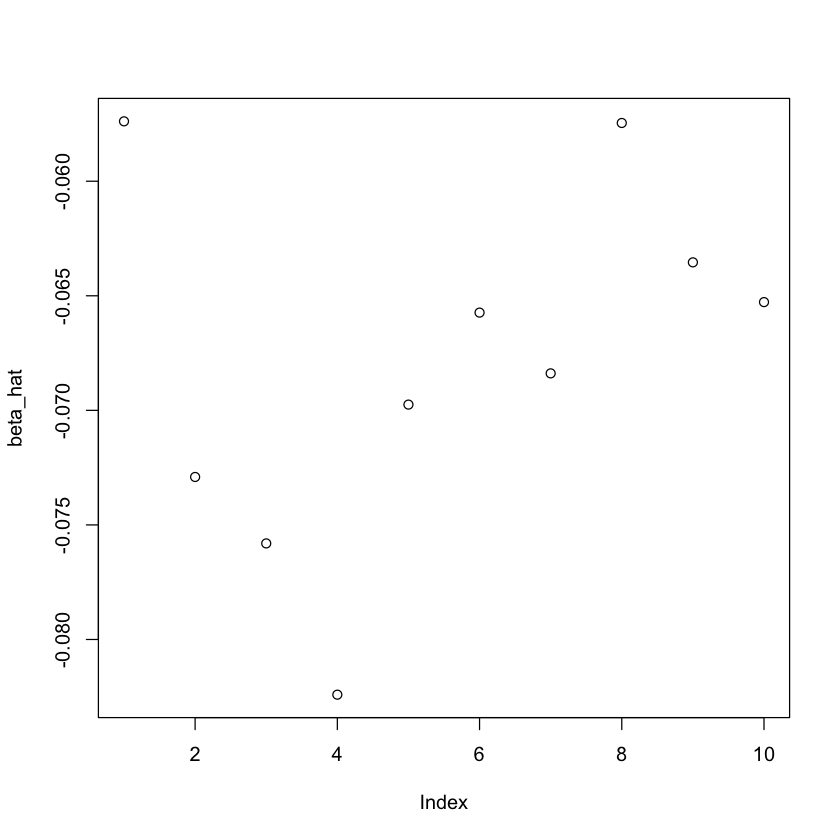

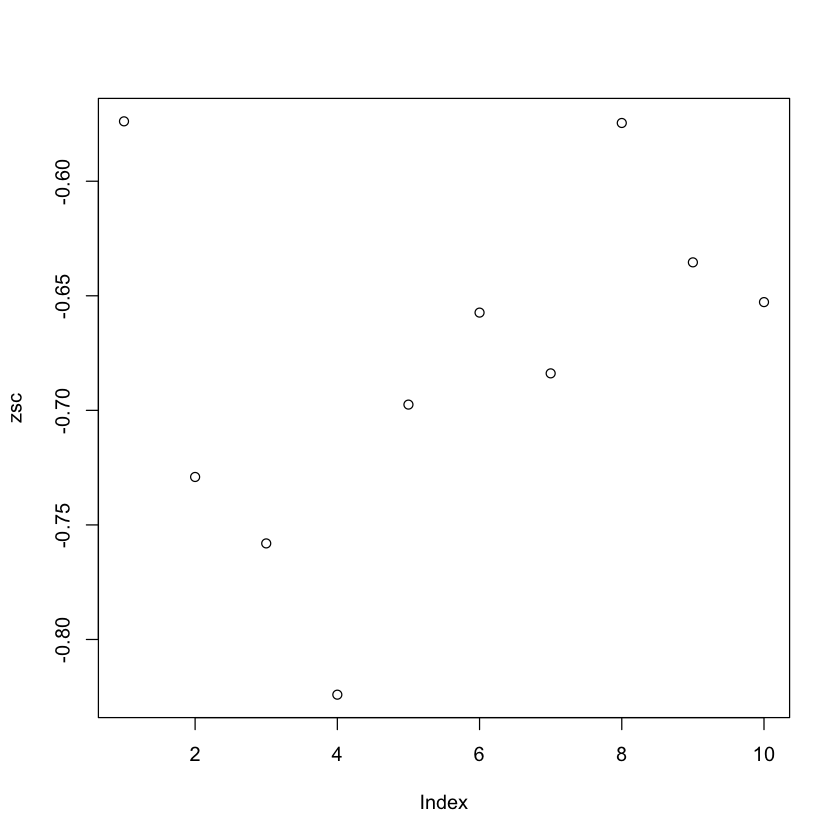

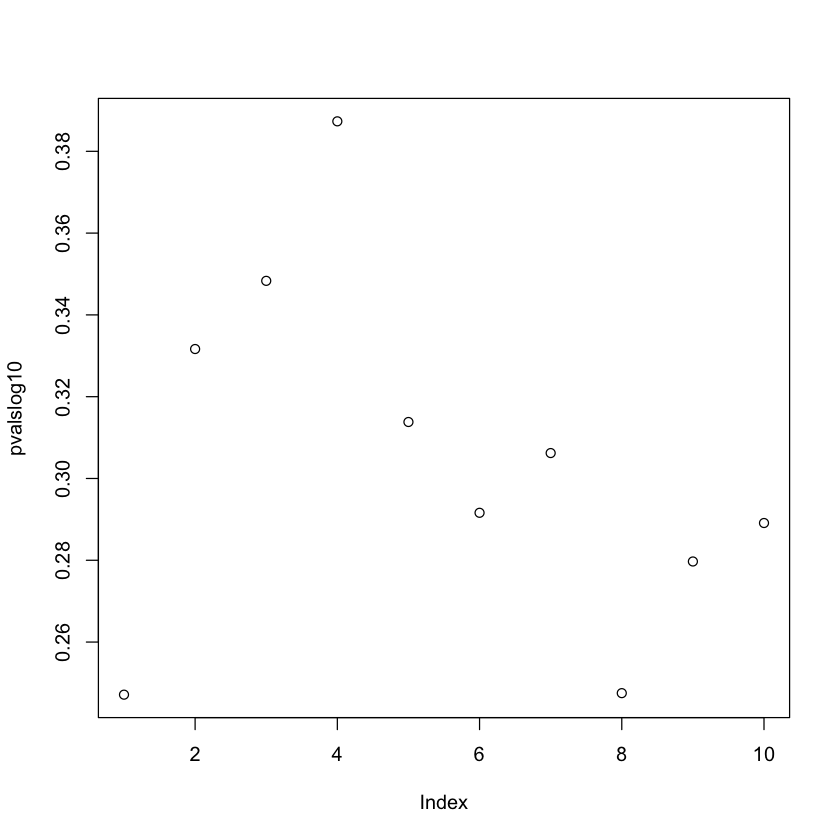

In [23]:
#visualizing betas/zsc/pvals
plot(beta_true)
plot(beta_hat)
plot(zsc)
plot(pvalslog10)

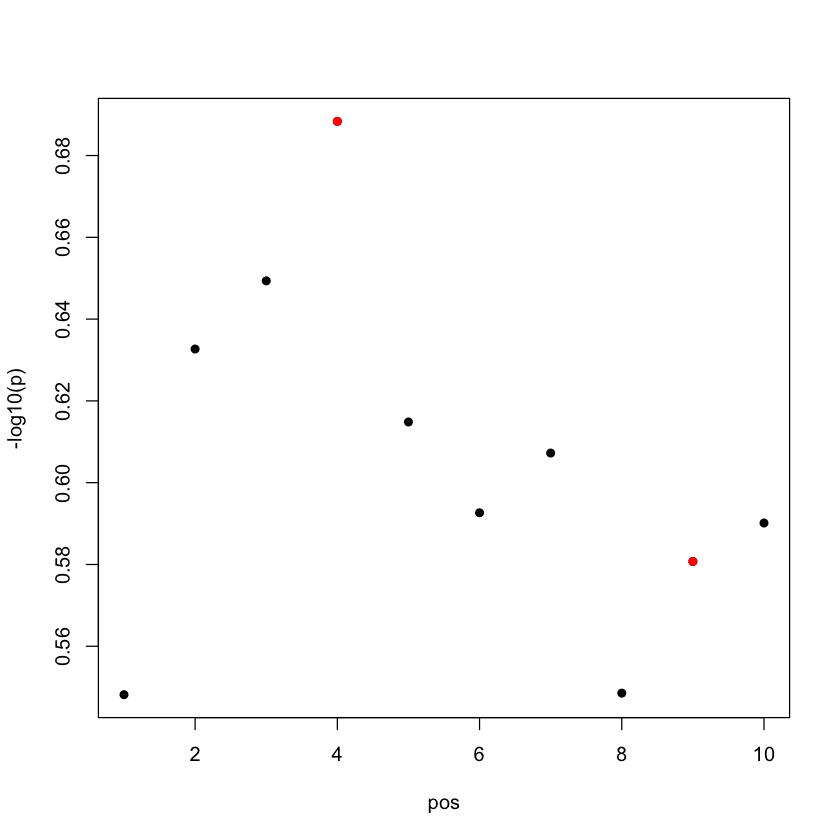

In [24]:
#fancier manhattan plot; red is the causal we are going to search for
susie_plot(zsc,y="z",b=beta_true)

[1] 1 8

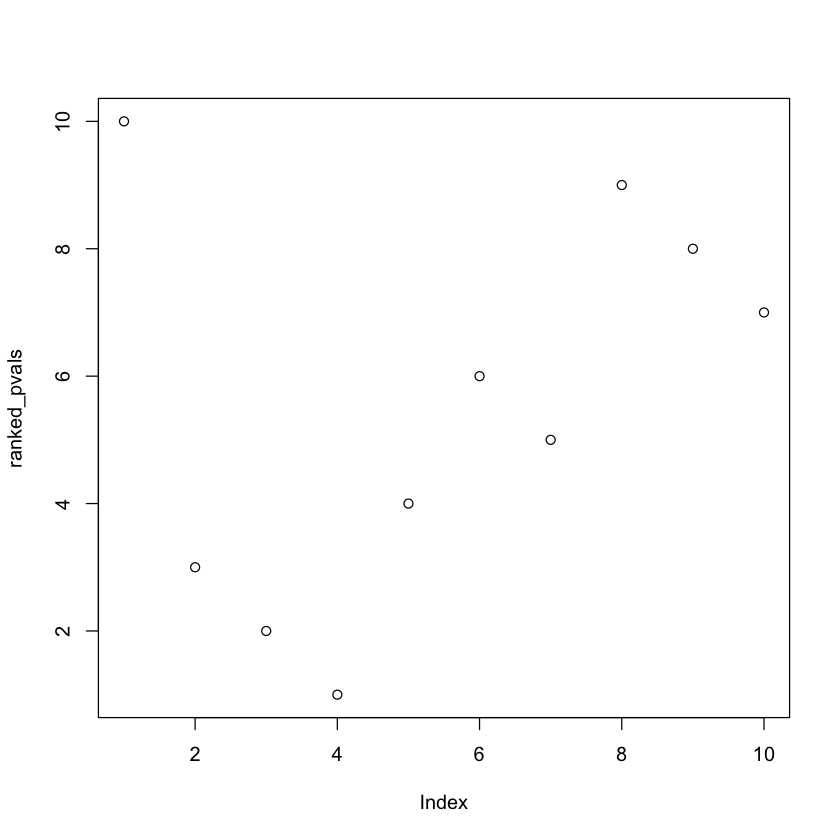

In [25]:
#Inference 1 (simplest): finding causal variant by ranking of pvalues
ranked_pvals = (M +1- rank(pvalslog10,ties.method= "random"))

#only look at the causal variants
causals_ranked_pvals = ranked_pvals *C
plot(ranked_pvals)
#where are the causals
causals_ranked_pvals [causals_ranked_pvals>0 ]

V1  V2  V3  V4  V5  V6  V7  V8  V9 V10 
  1   2   3   4   5   6   7   8   9  10

[1] 4

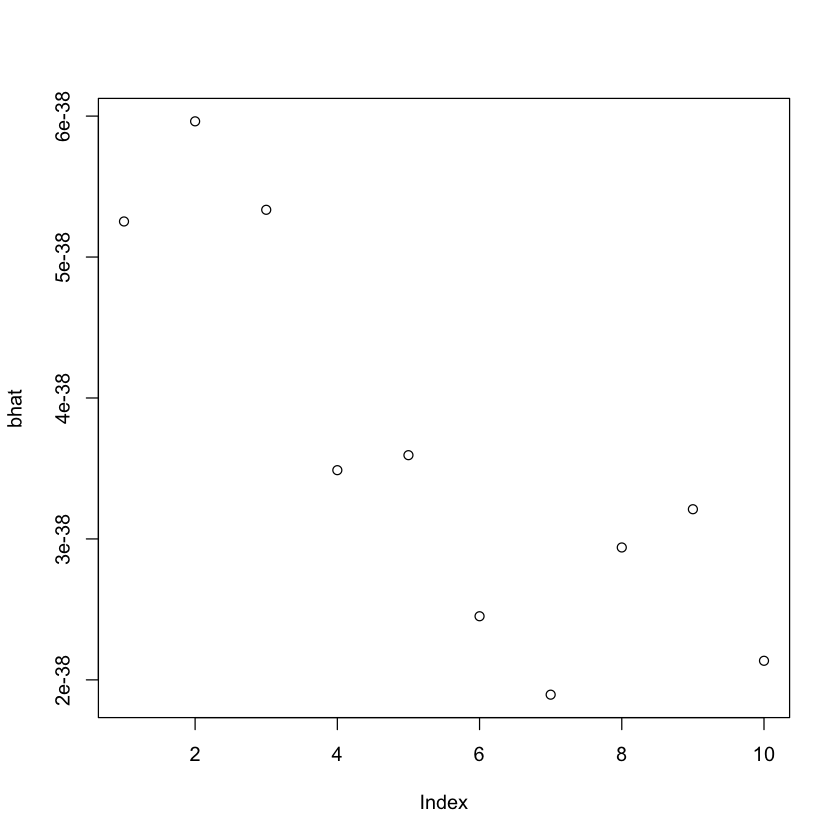

In [26]:
#Inference 2 : joint fit of all variants using no penalization

alpha = 0
y.fit = glmnet::glmnet(X,y,alpha = alpha,intercept = FALSE)
y.cv  = glmnet::cv.glmnet(X,y,alpha = alpha,intercept = FALSE,
                         lambda = y.fit$lambda)
bhat  = glmnet::predict.glmnet(y.fit,type ="coefficients",
                               s = y.cv$lambda.min)[-1,1]

#bhat contains the fit 
#lets look at the non-zero entries
which(bhat>0)
which(beta_true>0)
plot(bhat)

named integer(0)

[1] 4

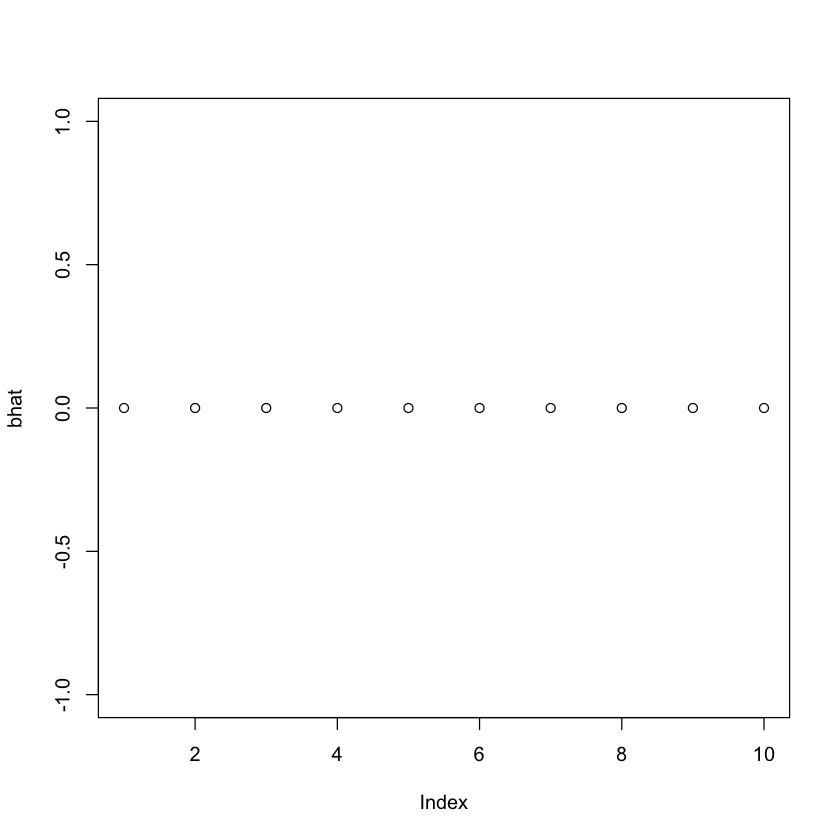

In [27]:
#Inference 3 (LASSO): joint fit of all variants using penalization

alpha = 1
y.fit = glmnet::glmnet(X,y,alpha = alpha,intercept = FALSE)
y.cv  = glmnet::cv.glmnet(X,y,alpha = alpha,intercept = FALSE,
                         lambda = y.fit$lambda)
bhat  = glmnet::predict.glmnet(y.fit,type ="coefficients",
                               s = y.cv$lambda.min)[-1,1]

#bhat contains the fit 
#lets look at the non-zero entries
which(bhat>0)
which(beta_true>0)
plot(bhat)




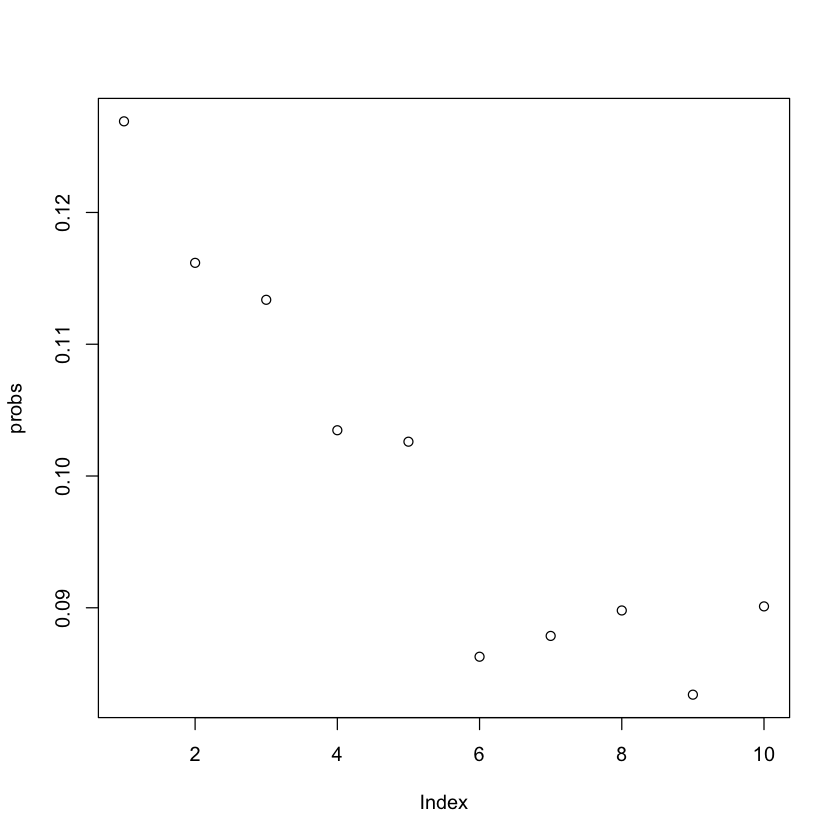

In [28]:
#Inference 4 : very simple Probabilistic fine-mapping
modelliks = rep (-9999, M)

for (i in seq(1:M)){
     modelliks [i] = logLik(lm(y~X[,i]))
}

modelliks = modelliks - max(modelliks)
probs = exp(modelliks)/sum(exp(modelliks))
plot(probs)


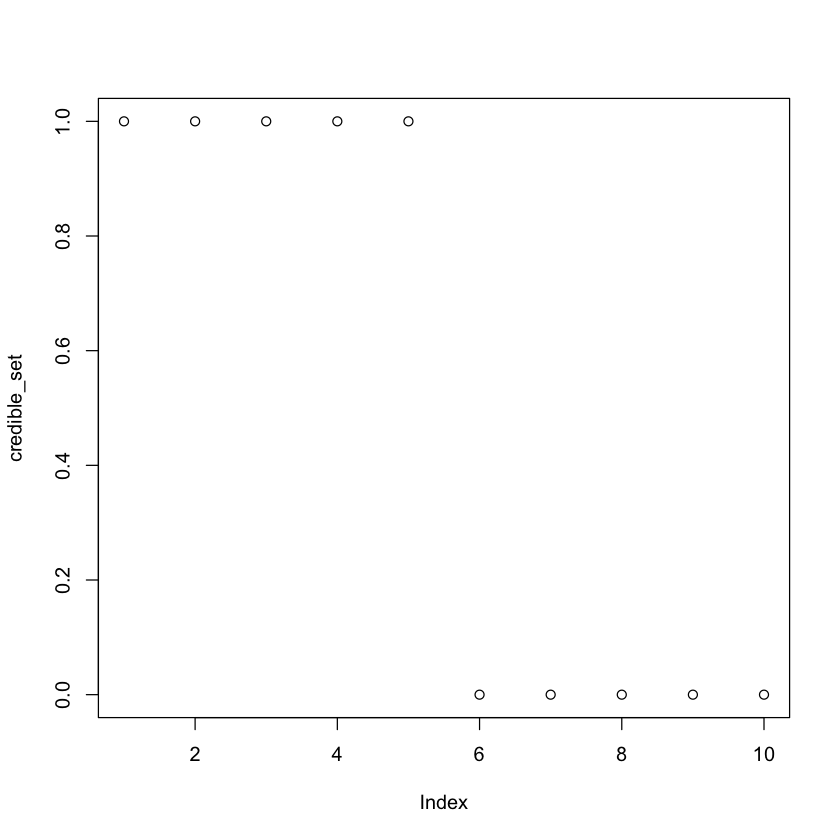

In [29]:
#credible sets: probabilistic fine-mapping allows for credible sets:
#traditionally defined as number of variants to include to capture 95% of all causals
#under 1 causal assumption we don't need the LD (see Maller et al NG 2012)

rankprobs = M+1-rank(probs)

#the confidence we desire
#Q investigate 0.1 0.5 0.9 0.99
confidence= 0.5

credible_set = rep (0, M)
sum = 0
for (i in seq(1:M)){
    if(sum < confidence){
        credible_set [rankprobs[i]] = 1
        sum = sum + probs [rankprobs[i]] 
        }
}
plot (credible_set)


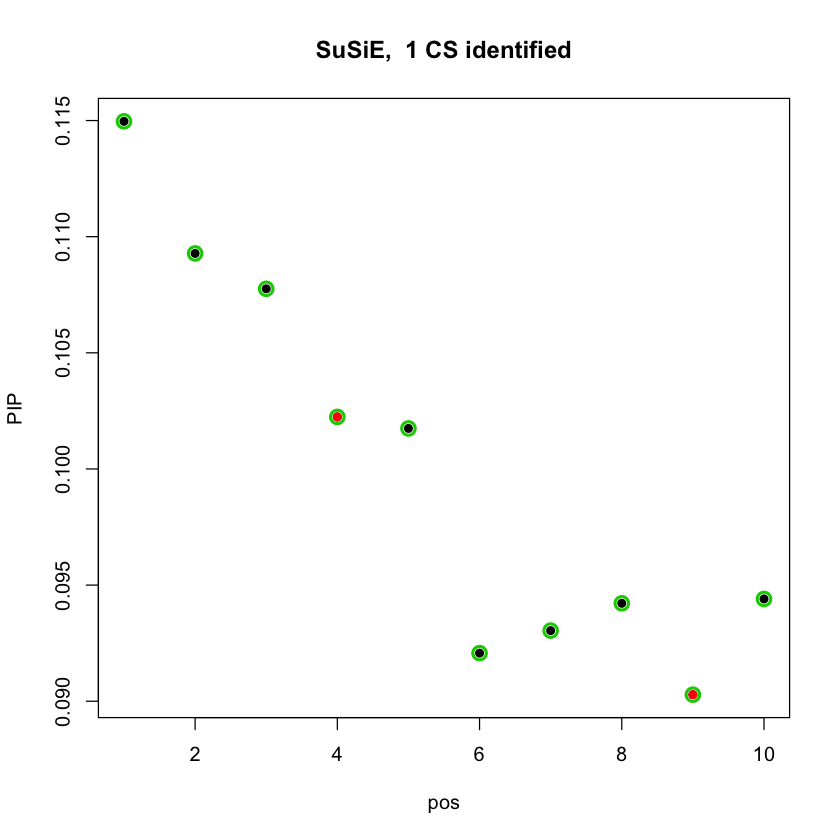

In [30]:
#Inference 5 : complex Probabilistic fine-mapping that allows for multiple causal variants

#here we will employ susie (many other methods exist, CAVIAR, CAVIARBF, FINEMAP, SusieR, etc...)

#specify to susie how many sets to search for/expect

#Q investigate L=1,2,3,4,....
fitted = susieR::susie(X, y, L=1,
               estimate_residual_variance=TRUE, 
               scaled_prior_variance=0.2,
               tol=1e-3, track_fit=TRUE, min_abs_corr=0.1)


#plot in a nice format
susieR::susie_plot(fitted, y='PIP', b=beta_true, max_cs=0.4, main = paste('SuSiE, ', length(fitted$sets$cs), 'CS identified'))






In [32]:
##############Exercise 2: multiple causal variants at a region
##############GOAL: To Assess impact of LD, effect size, sample size in fine-mapping
##############Compare standard strategies to identify causal variant under simple 1 causal scenario
##############TODO: Answer Questions marked with Q below to investigate the impact of its parameters  
############## on fine-mapping performance


#random seed; 
set.seed(1)

##############Parameters:

#number of variants/SNPs; 
#Q1: Investigate the performance of fine-mapping as number of causals increases M= 10, 50,100,500
#Q1: Which of the 5 inference methods below gives the correct answer? 
M = 10

#number of individuals; 
#Q2: Investigate the performance of fine-mapping as number of individuals increases N=100,1000,10000,100000
#Q2: Which of the 5 inference methods below gives the correct answer? 
N = 100

#strength of causal effects (in variance/heritability terms); 
#Q3: Investigate the performance of effect size h2g=0.001, 0.01, 0.05, 0.1 on fine-mapping accuracy
#Q3: which method of inferrence of causal variant gives correct answer
h2g = 0.01

#strength of LD; LD will decay exponentially farther from diagonal; 
#Q4: investigate impact of LD (theta=0,0.5,0.95,0.995) on fine-mapping inference
#Q4: Will any method give the correct answer?
theta=0.995


#Q5: Explore the interaction between M, N and effect size; what happens to the inferrence as number 
# of individuals/effect size increase? Which matters more? M, N or LD?


#causal vector indicator; this will specify which variants are causal and which ones are not
C = rep(0,M)
p = rep (1/M,M)


#multiple causals variant simulation;

C = rbinom(n = M, size = 1, p = p)

C


[1] 0 0 0 1 0 0 1 0 0 0

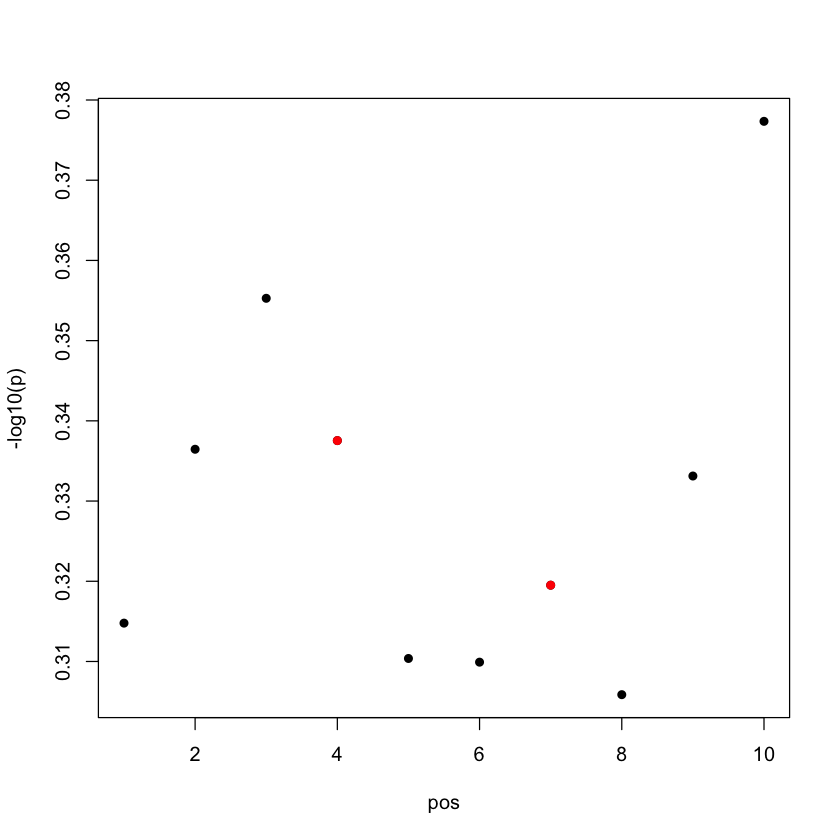

In [33]:
#generate an LD matrix
#we set SNPs close to each other to have high correlation according to theta 
ld = diag(1,M,M)
for(row in 1:nrow(ld)) {
    for(col in row:ncol(ld))
    {
        ld[row,col] = theta^(col-row)
        ld[col,row] = ld [row,col]    
    }
}

#generate causal effects according to variance parameter
#sample effect sizes at all SNPs
alpha = rnorm(n = M, mean = 0, sd = sqrt(h2g/sum(C)))
#keep non-zero effects only at causal variants
beta_true = C*alpha
#beta_true is the true causal effect size vector

#sample a matrix of genotypes according to the LD correlation structure
#many ways to do it; for simplicity we just sample from a 
#multivariate normal distr with covariance specified by LD
#this step will take longer if N, M are large
#the LD matrix needs to be a covariance matrix

X = mvrnorm(n = N, mu = rep(0,M), Sigma = ld)

#generate phenotype as linear combination of genotypes with causal effects plus random noise
y = X %*% beta_true + rnorm(N,1-h2g)

#now that we have genotype and phenotype we can perform inference
#usual inference is marginal regression of y on every SNP indepentently
#this gives us observed effects in GWAS as function of LD
beta_hat = mvrnorm(n = 1, mu = ld%*%beta_true, Sigma = ld*(1-h2g)/N)

#z-scores for association in GWAS
zsc = beta_hat*sqrt(N)

#p-values in GWAS
pvalslog10 = -log10(pchisq(zsc^2,1,lower.tail=F))


#visualizing betas/zsc/pvals
#plot(beta_true)
#plot(beta_hat)
#plot(zsc)
#plot(pvalslog10)


#fancier manhattan plot; red is the causal we are going to search for
susie_plot(zsc,y="z",b=beta_true)


[1] 3 6

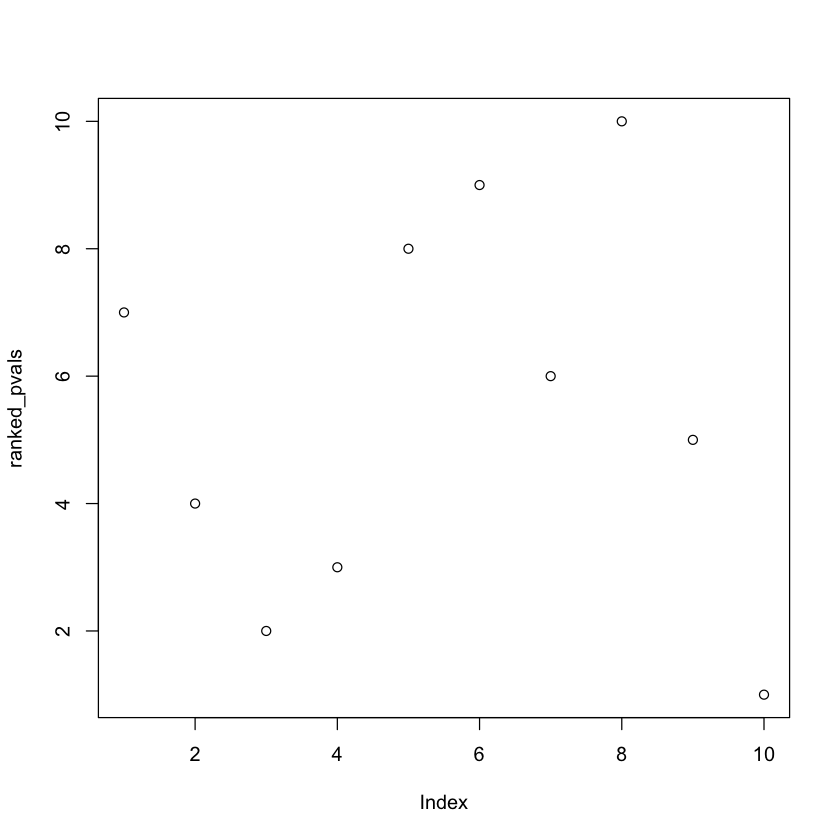

In [34]:
#Inference 1 (simplest): finding causal variant by ranking of pvalues
ranked_pvals = (M +1- rank(pvalslog10,ties.method= "random"))

#only look at the causal variants
causals_ranked_pvals = ranked_pvals *C
plot(ranked_pvals)
#where are the causals
causals_ranked_pvals [causals_ranked_pvals>0 ]

V1  V2  V3  V4  V5  V6  V7  V8  V9 V10 
  1   2   3   4   5   6   7   8   9  10

[1] 4 7

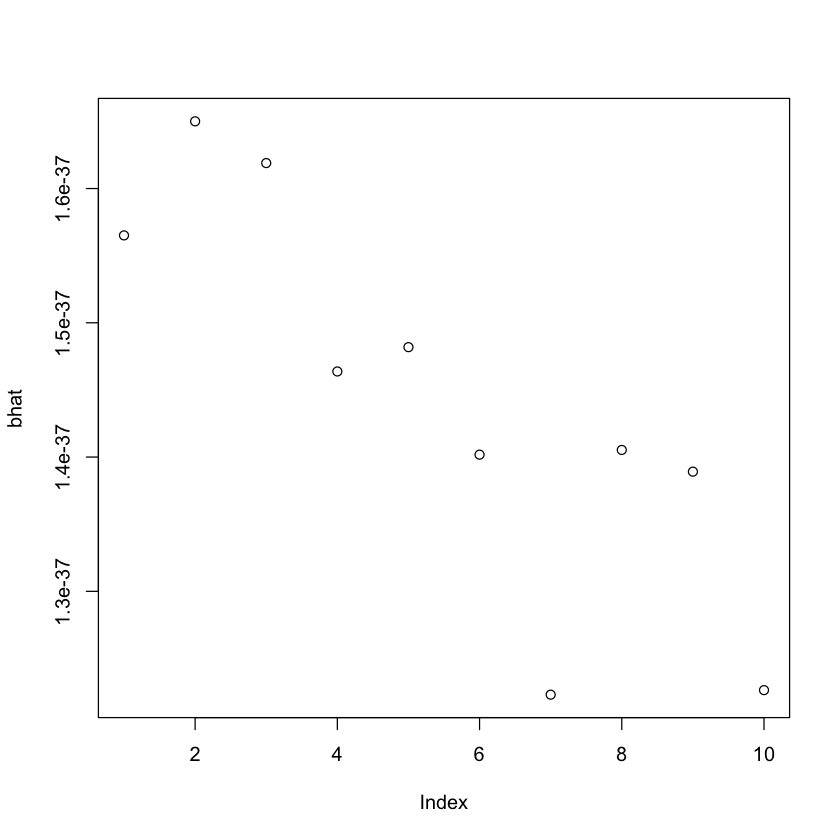

In [35]:
#Inference 2 : joint fit of all variants using no penalization

alpha = 0
y.fit = glmnet::glmnet(X,y,alpha = alpha,intercept = FALSE)
y.cv  = glmnet::cv.glmnet(X,y,alpha = alpha,intercept = FALSE,
                         lambda = y.fit$lambda)
bhat  = glmnet::predict.glmnet(y.fit,type ="coefficients",
                               s = y.cv$lambda.min)[-1,1]

#bhat contains the fit 
#lets look at the non-zero entries
which(bhat>0)
which(beta_true>0)
plot(bhat)

named integer(0)

[1] 4 7

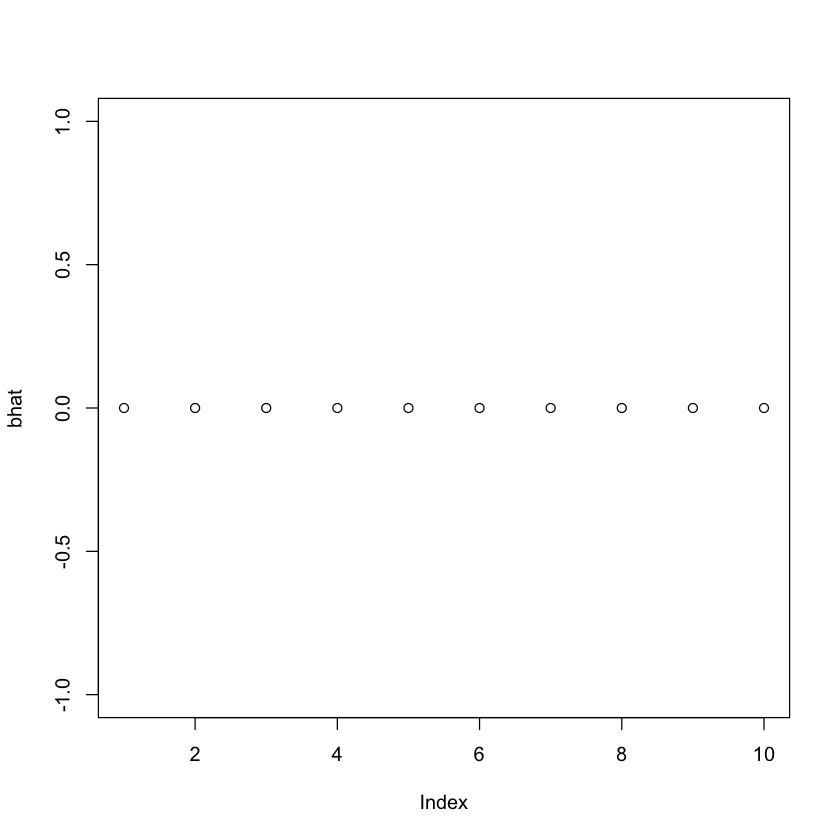

In [36]:
#Inference 3 (LASSO): joint fit of all variants using penalization

alpha = 1
y.fit = glmnet::glmnet(X,y,alpha = alpha,intercept = FALSE)
y.cv  = glmnet::cv.glmnet(X,y,alpha = alpha,intercept = FALSE,
                         lambda = y.fit$lambda)
bhat  = glmnet::predict.glmnet(y.fit,type ="coefficients",
                               s = y.cv$lambda.min)[-1,1]

#bhat contains the fit 
#lets look at the non-zero entries
which(bhat>0)
which(beta_true>0)
plot(bhat)

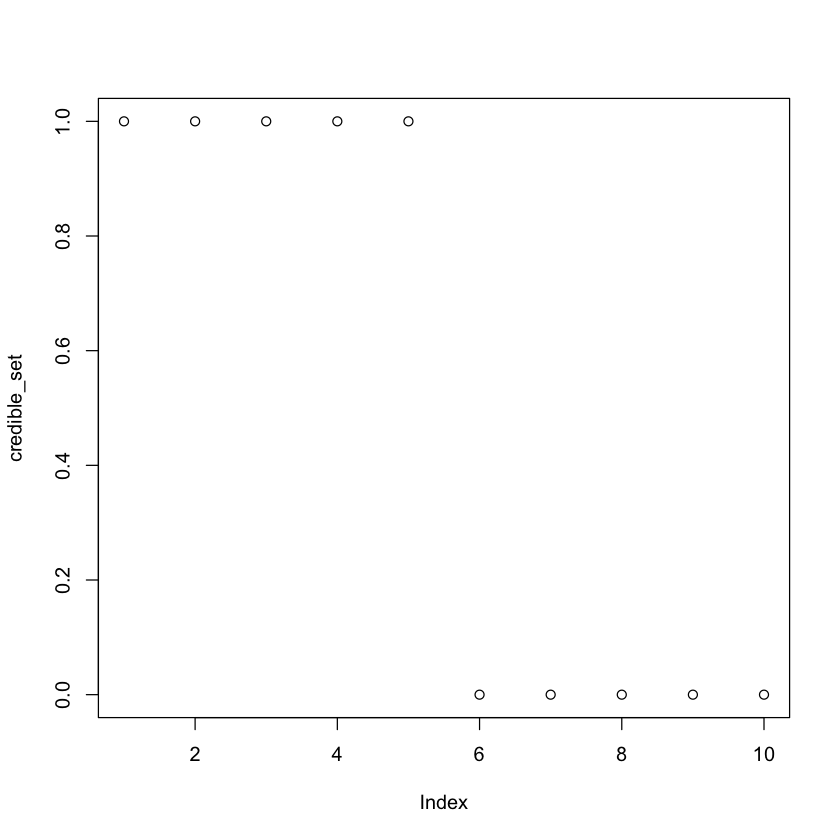

In [37]:
#Inference 4 : very simple Probabilistic fine-mapping
modelliks = rep (-9999, M)

for (i in seq(1:M)){
     modelliks [i] = logLik(lm(y~X[,i]))
}

modelliks = modelliks - max(modelliks)
probs = exp(modelliks)/sum(exp(modelliks))

#plot(probs)
#credible sets: probabilistic fine-mapping allows for credible sets:
#traditionally defined as number of variants to include all causals with 95% confidence
#new ways to define credible sets in Susie
#under 1 causal assumption we don't need the LD (see Maller et al NG 2012)

rankprobs = M+1-rank(probs)

#the confidence we desire
#Q investigate 0.1 0.5 0.9 0.99
confidence= 0.5

credible_set = rep (0, M)
sum = 0
for (i in seq(1:M)){
    if(sum < confidence){
        credible_set [rankprobs[i]] = 1
        sum = sum + probs [rankprobs[i]] 
        }
}
plot (credible_set)




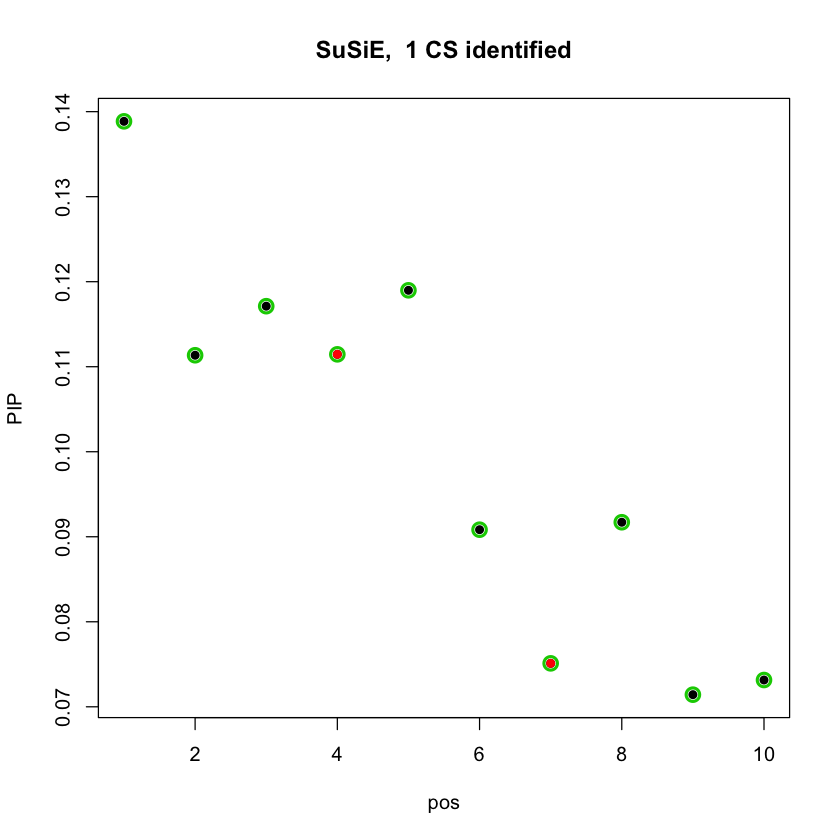

In [38]:
#Inference 5 : complex Probabilistic fine-mapping that allows for multiple causal variants

#here we will employ susie (many other methods exist, CAVIAR, CAVIARBF, FINEMAP, SusieR, etc...)

#specify to susie how many sets to search for/expect

#Q investigate L=1,2,3,4,....
fitted = susieR::susie(X, y, L=5,
               estimate_residual_variance=TRUE, 
               scaled_prior_variance=0.2,
               tol=1e-3, track_fit=TRUE, min_abs_corr=0.1)


#plot in a nice format
susieR::susie_plot(fitted, y='PIP', b=beta_true, max_cs=0.4, main = paste('SuSiE, ', length(fitted$sets$cs), 'CS identified'))





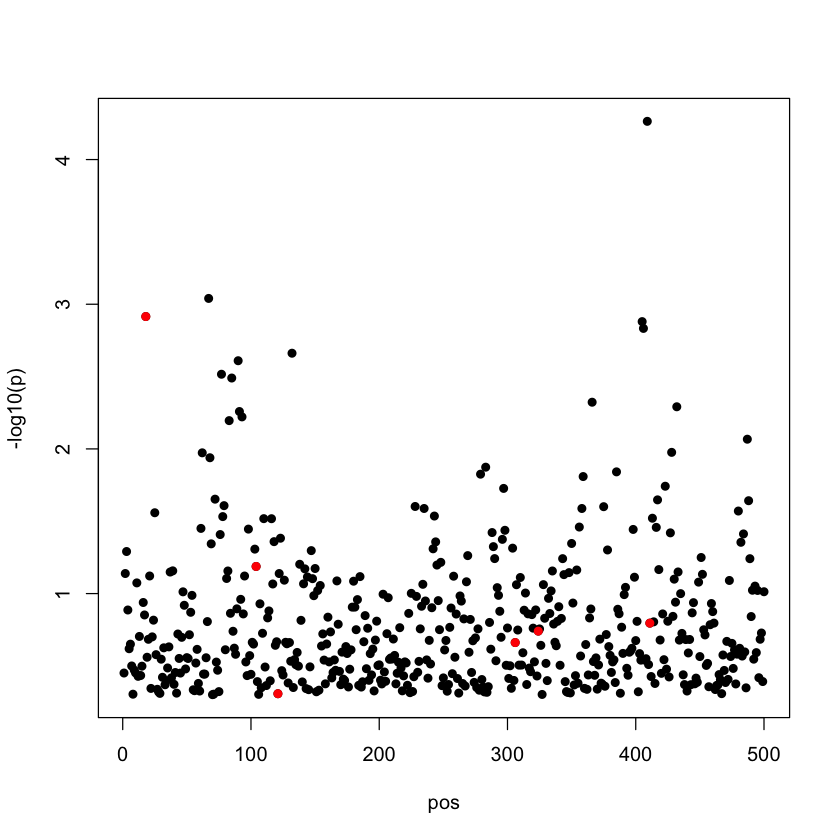

In [43]:
##############Exercise 3: multiple causal variants at a region
##############GOAL: To Assess impact of realistic LD in fine-mapping
##############Compare standard strategies to identify causal variant under simple 1 causal scenario
##############TODO: Answer Questions marked with Q below to investigate the impact of its parameters  
############## on fine-mapping performance


#random seed; 
set.seed(1)
##############Parameters:



#number of variants/SNPs; 

#Q1: Investigate the performance of fine-mapping in realistic LD setting; vary ldlow, ldhigh 
#Q1: Which of the 5 inference methods below gives the correct answer? 

ld = ldlow

M = nrow(ld)


#number of individuals; 
#Q2: Investigate the performance of fine-mapping as number of individuals increases N=100,1000,10000,100000
#Q2: Which of the 5 inference methods below gives the correct answer? 
N = 100

#strength of causal effects (in variance/heritability terms); 
#Q3: Investigate the performance of effect size h2g=0.001, 0.01, 0.05, 0.1 on fine-mapping accuracy
#Q3: which method of inferrence of causal variant gives correct answer
h2g = 0.01


C = rbinom(n = M, size = 1, p = p)




#generate causal effects according to variance parameter
#sample effect sizes at all SNPs
alpha = rnorm(n = M, mean = 0, sd = sqrt(h2g/sum(C)))

#keep non-zero effects only at causal variants
beta_true = C*alpha
#beta_true is the true causal effect size vector

#now that we have genotype and phenotype we can perform inference
#usual inference is marginal regression of y on every SNP indepentently
#this gives us observed effects in GWAS as function of LD
beta_hat = mvrnorm(n = 1, mu = ld%*%beta_true, Sigma = ld*(1-h2g)/N)

#z-scores for association in GWAS
zsc = beta_hat*sqrt(N)

#p-values in GWAS
pvalslog10 = -log10(pchisq(zsc^2,1,lower.tail=F))


#visualizing betas/zsc/pvals
#plot(beta_true)
#plot(beta_hat)
#plot(zsc)
#plot(pvalslog10)


#fancier manhattan plot; red is the causal we are going to search for
susie_plot(zsc,y="z",b=beta_true)


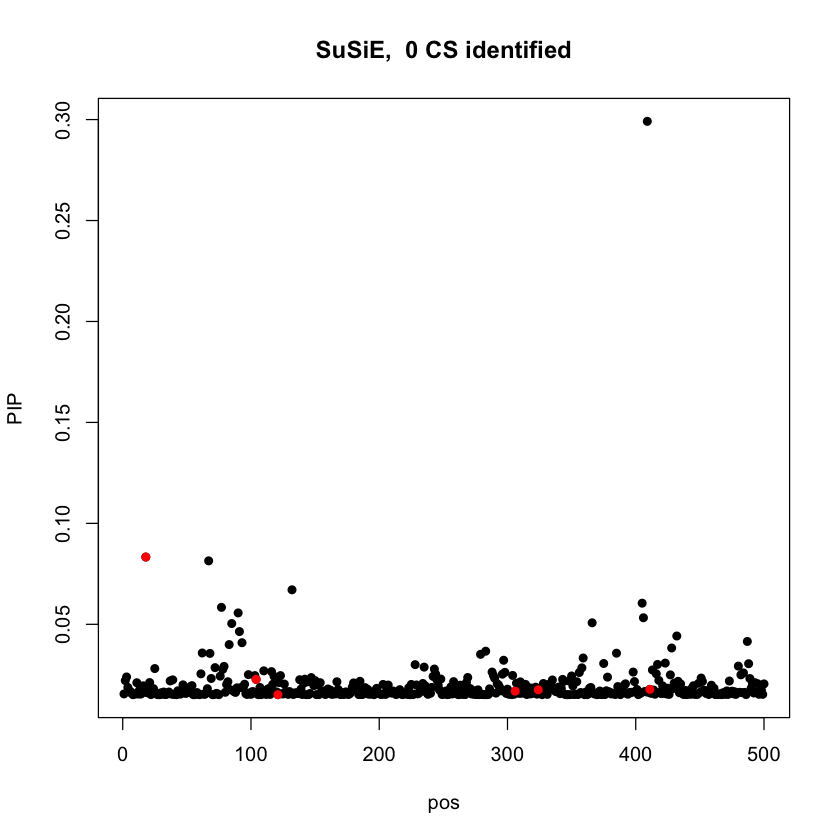

In [45]:
#inference using Susie from summary statistics
fitted <- susie_rss(zsc, 
                    ld, 
                    L = 10,
                    estimate_residual_variance = TRUE, 
                    estimate_prior_variance = TRUE)
                    
susie_plot(fitted, y="PIP", b= beta_true, max_cs=0.4, main = paste('SuSiE, ', length(fitted$sets$cs), 'CS identified'))

[1] 6.675655

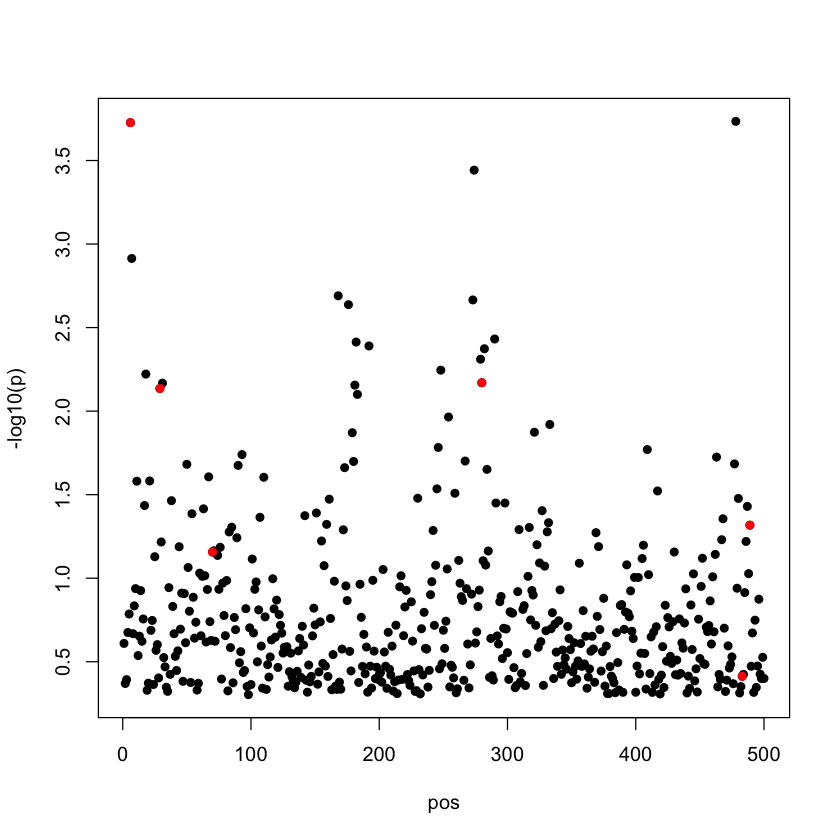

In [46]:
##############Exercise 4
##############Complex simulation scenario: many causal variants
##############Impact of prior functional enrichment for fine-mapping 

#random seed; 
set.seed(1)
##############Parameters:



#number of individuals; 
#Q1: investigate other N=1000,10000,100000
N = 1000

#strength of causal effects (in variance/heritability terms); 
#Q2: investigate other h2g=0.001, 0.01, 0.05, 0.1
h2g = 0.01

#causal vector indicator; this will specify which variants are causal and which ones are not

C = rep(0,M)
A0 = rep(1, M)
A1 = rbinom(n = M, size = 1, p = 0.25)

#Q3: increase gamma1 and note how fine-mapping accuracy increases/decreases
gamma0 = -6
gamma1 = 3
p = 1/(1 + exp(-A0*gamma0 -A1*gamma1))
sum(p)


#multiple causals variant simulation;

C = rbinom(n = M, size = 1, p = p)

#use realistic ld = ldlow,ldhigh
ld = ldlow

M = nrow(ld)


#generate causal effects according to variance parameter
#sample effect sizes at all SNPs
alpha = rnorm(n = M, mean = 0, sd = sqrt(h2g/sum(C)))

#keep non-zero effects only at causal variants
beta_true = C*alpha
#beta_true is the true causal effect size vector

#now that we have genotype and phenotype we can perform inference
#usual inference is marginal regression of y on every SNP indepentently
#this gives us observed effects in GWAS as function of LD
beta_hat = mvrnorm(n = 1, mu = ld%*%beta_true, Sigma = ld*(1-h2g)/N)

#z-scores for association in GWAS
zsc = beta_hat*sqrt(N)

#p-values in GWAS
pvalslog10 = -log10(pchisq(zsc^2,1,lower.tail=F))

#visualizing betas/zsc/pvals
#plot(beta_true)
#plot(beta_hat)
#plot(zsc)
#plot(pvalslog10)


#fancier manhattan plot; red is the causal we are going to search for
susie_plot(zsc,y="z",b=beta_true)

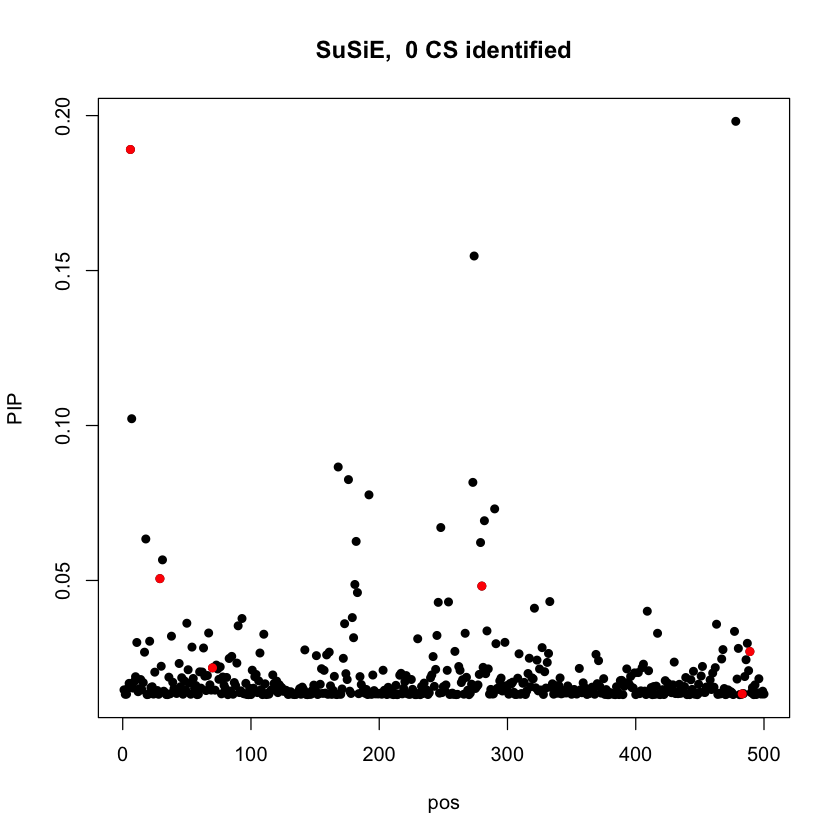

In [47]:
fitted <- susie_rss(zsc, 
                    ld, 
                    L = 10,
                    estimate_residual_variance = TRUE, 
                    estimate_prior_variance = TRUE)
                    
susie_plot(fitted, y="PIP", b= beta_true, max_cs=0.4, main = paste('SuSiE, ', length(fitted$sets$cs), 'CS identified'))

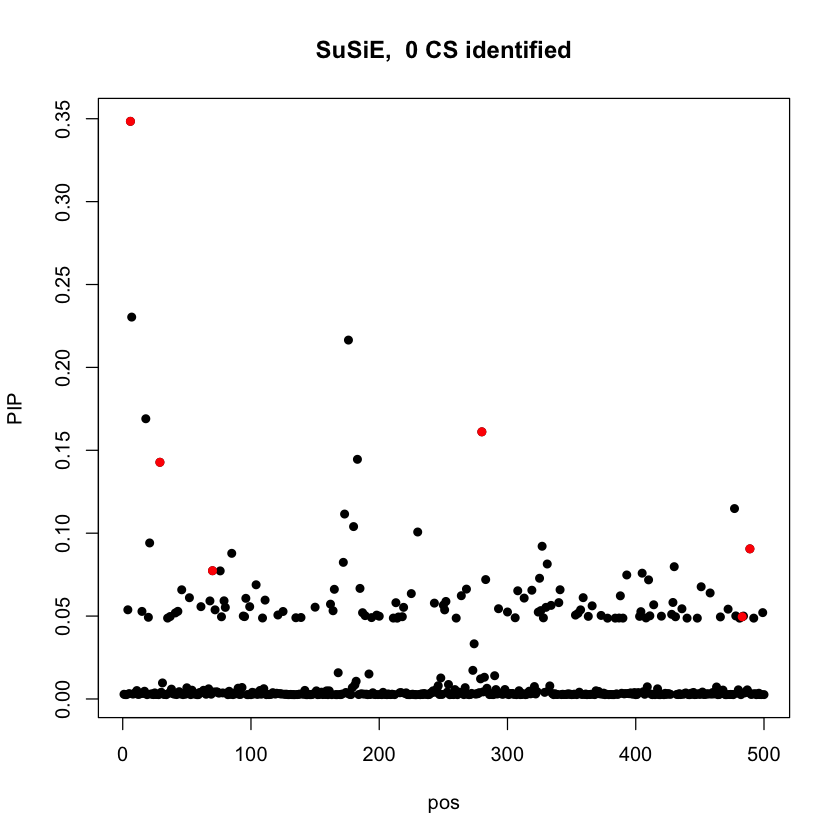

In [48]:
fitted <- susie_rss(zsc, 
                    ld, 
                    L = 10,
                    estimate_residual_variance = TRUE, 
                    prior_weight = p,
                    estimate_prior_variance = TRUE)
                    
susie_plot(fitted, y="PIP", b= beta_true, max_cs=0.4, main = paste('SuSiE, ', length(fitted$sets$cs), 'CS identified'))